## Tabulations and figures for CCS-lobbying-activity analysis
Lindsey Gulden, lindsey@legupdata.com
October 2024

In [2]:

import pandas as pd

from utils.io import yaml_to_dict
from projects.lobbying.postproc_utils import terms_present
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

### PATHS TO POSTPROCESSED DATA, YAML CONFIGURATIONS

In [4]:
PATH_TO_POSTPROCESSED_FILINGS = (
    "/Volumes/Samsung_T5/data/lobbying/ccs2/jan14_postprocessed_filings.csv"
)
PATH_TO_POSTPROCESSED_STEEL_INDUSTRY_FILINGS = "/Volumes/Samsung_T5/data/lobbying/steel_iron_organizations2/jan14_postprocessed_filings.csv"

PATH_TO_POSTPROCESSED_BIG_SPENDERS_FILINGS = "/Volumes/Samsung_T5/data/lobbying/oil_and_gas_orgs2/jan14_postprocessed_filings.csv"

PATH_TO_POSTPROC_SPECS_YAML = "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/definitions/ccs_postproc_specifications.yml"

PATH_TO_HIGHER_EDUCATION_POSTPROC_LOBBYING_FILINGS = (
    "/Volumes/Samsung_T5/data/lobbying/univ/jan14_postprocessed_filings.csv"
)

In [5]:
def trim_dates(
    df: pd.DataFrame,
    yr: int,
    period: int,
    yr_col: str,
    period_col: str,
    how: str = "lte",
):
    num_period_col = "numeric_filing_period"
    df[num_period_col] = df[period_col].replace(
        {
            "first_quarter": 1,
            "second_quarter": 2,
            "third_quarter": 3,
            "fourth_quarter": 4,
            "mid_year": 2,
            "year_end": 4,
        }
    )
    df[yr_col] = df[yr_col].astype(int)
    if how == "lte":
        return df.loc[
            (df[yr_col] < yr) | ((df[yr_col] == yr) & df[num_period_col] <= period)
        ]
    elif how == "lt":
        return df.loc[
            (df[yr_col] < yr) | ((df[yr_col] == yr) & df[num_period_col] < period)
        ]
    elif how == "gte":
        return df.loc[
            (df[yr_col] > yr) | ((df[yr_col] == yr) & df[num_period_col] >= period)
        ]
    elif how == "gt":
        return df.loc[
            (df[yr_col] > yr) | ((df[yr_col] == yr) & df[num_period_col] > period)
        ]
    else:
        raise ValueError(
            'trim_dates paramter how must be one of the following strings: "lte", "lt", "gte", "gt"'
        )

### Load postprocessed data, summarize general counts

In [6]:
# df = pd.read_csv(PATH_TO_POSTPROCESSED_FILINGS)
df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_FILINGS),
    yr=2024,
    period=3,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)
df[
    [
        "ccs_company",
        "contains_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "h2_mention_core_ff",
        "potentially_ccs",
    ]
].sum()

ccs_company                988
contains_description      9082
ccs_bills                 3352
ccs_bills_number_only     3800
bills_with_ccs_terms      3751
definitely_ccs           13209
very_likely_ccs          14776
likely_ccs               15252
h2_mention_core_ff        2302
potentially_ccs          31415
dtype: int64

### Summarize the mapping of names of organizations used on filing documents to single names 
(e.g. "EXXON MOBIL CORPORATION" and "EXXONMOBIL" are both mapped to "EXXONMOBIL")

In [7]:
companies_df = (
    df[
        [
            "client_name_on_filing_document",
            "client_id",
            "organization",
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "definitely_ccs",
        ]
    ]
    .groupby(["client_name_on_filing_document", "client_id"])
    .agg(
        {
            "definitely_ccs": "max",
            "organization": "first",
            "sector": "first",
            "lumped_sector": "first",
            "very_lumped_sector": "first",
        }
    )
)
companies_df.reset_index(inplace=True)
companies_df.sort_values(
    by=["organization", "client_name_on_filing_document", "client_id"], ascending=True
).to_clipboard()

### Subset data to lobbying activities identified as 'definitey CCS'. Compute percentages of total dollars and lobbying/entity contacts

In [8]:
# for plotting and analysis, subset to only the 'definitely ccs' lobbying activities
df = df.loc[df.definitely_ccs == 1]

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

tot_dollars_since_2019 = df.loc[df.filing_year > 2018].lobbying_activity_usd.sum()

tot_contacts_since_2019 = df.loc[df.filing_year > 2018].n_entities_lobbied.sum()

# compute percentages of total dollars and entity contacts for all years
df["pct_of_lobbying_dollars_definitely_ccs"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts_definitely_ccs"] = [
    100 * x / tot_contacts for x in df.n_entities_lobbied
]

# compute percentages of total dollars and entity contacts since 2019
df["pct_of_lobbying_dollars_definitely_ccs_since_2019"] = [
    100 * x / tot_dollars_since_2019 if y > 2018 else 0
    for x, y in zip(df.lobbying_activity_usd, df.filing_year)
]

df["pct_of_entity_contacts_definitely_ccs_since_2019"] = [
    100 * x / tot_contacts_since_2019 if y > 2018 else 0
    for x, y in zip(df.n_entities_lobbied, df.filing_year)
]

In [9]:
print("Dollars spent:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].lobbying_activity_usd.sum()
print(f"From Jan 1 2019 through September 30 2024 ${since_2019:.0f}")
allyears = df.loc[(df.definitely_ccs == 1)].lobbying_activity_usd.sum()
print(f"From Jan 1 2005 through September 30 2024: ${allyears:.0f}")
print("")
print("Contacts made:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].n_entities_lobbied.sum()
print(f"From Jan 1 2019 through September 30 2024: {since_2019}")
allyears = df.loc[(df.definitely_ccs == 1)].n_entities_lobbied.sum()
print(f"From Jan 1 2005 through September 30 2024: {allyears}")
print("")
print(
    f"CCS lobbying contacts per work day since start of 2019: {since_2019 / (50 * 5 * 5.75):.1f}"
)

Dollars spent:
From Jan 1 2019 through September 30 2024 $438332200
From Jan 1 2005 through September 30 2024: $757852833

Contacts made:
From Jan 1 2019 through September 30 2024: 34109
From Jan 1 2005 through September 30 2024: 57564

CCS lobbying contacts per work day since start of 2019: 23.7


In [10]:
core_ff_sectors = yaml_to_dict(PATH_TO_POSTPROC_SPECS_YAML)["core_industry_sectors"]
ff_adjacent_sectors = yaml_to_dict(PATH_TO_POSTPROC_SPECS_YAML)[
    "industry_adjacent_sectors"
]
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying dollars"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying dollars"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying dollars"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels spends {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)

Core fossil-fuel-sector industry is responsible for 77% of CCS lobbying dollars
Core FF + FF-adjacent industry is responsible for 88% of CCS lobbying dollars
Non-fossil-fuel-sector industry is responsible for 3% of CCS lobbying dollars
Industry that directly profits from selling or burning fossil fuels spends 24 times as much as non-FF industry on CCS lobbying


In [11]:
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying contacts"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying contacts"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying contacts"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels contacts the federal government {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)

Core fossil-fuel-sector industry is responsible for 57% of CCS lobbying contacts
Core FF + FF-adjacent industry is responsible for 75% of CCS lobbying contacts
Non-fossil-fuel-sector industry is responsible for 6% of CCS lobbying contacts
Industry that directly profits from selling or burning fossil fuels contacts the federal government 10 times as much as non-FF industry on CCS lobbying


In [12]:
# Write out which detailed sectors are in each sector grouping:
for c in core_ff_sectors:
    print(f"{c.title()}")

print("")
for c in ff_adjacent_sectors:
    print(f"{c.title()}")

Oil And Gas
Investor Owned Utilities
Chemicals, Refining, And Plastics
Coal
Ccs
Independent Power Producers
Pipelines
Municipal And Cooperative Utilities
Power Sector General
Oilfield Services
Clean Hydrogen

Oil And Gas
Investor Owned Utilities
Chemicals, Refining, And Plastics
Coal
Biofuels
Energy Technology
Ccs
Independent Power Producers
Power Sector General
Air Transit
Railway
Pipelines
Municipal And Cooperative Utilities
Business Advocacy
Fuel Cell
Land Transit
Oilfield Services
Clean Hydrogen


### Which lumped sectors do the most CCS lobbying?

In [13]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["lumped_sector"])
    .agg(
        {
            # "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df  # .to_clipboard()

,very_lumped_sector,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars_definitely_ccs,pct_of_entity_contacts_definitely_ccs
lumped_sector,,,,,
FOSSIL FUEL,FOSSIL-FUEL,2.646067e+08,15050,34.915320,26.144813
INVESTOR-OWNED-POWER-SECTOR,POWER-UTILITIES,2.344070e+08,9737,30.930413,16.915086
CHEMICALS,CHEMICALS,5.500353e+07,3895,7.257811,6.766382
TRANSPORT,TRANSPORT,3.563398e+07,2898,4.701965,5.034396
NON-FF-INDUSTRY,NON-FF-INDUSTRY,2.440960e+07,3207,3.220889,5.571190
BIOFUEL-SYNFUEL,BIOFUEL-SYNFUEL,1.999780e+07,3850,2.638745,6.688208
ENGINEERING-TECH,ENGINEERING-TECH,1.977289e+07,2931,2.609068,5.091724
BUSINESS-ADVOCACY,BUSINESS-ADVOCACY,1.696684e+07,1280,2.238805,2.223612
MUNICIPAL-UTILITIES,POWER-UTILITIES,1.694392e+07,1497,2.235779,2.600584


### Which organizations do the most lobbying for CCS?

In [14]:
df[["organization", "lobbying_activity_usd"]].groupby(
    ["organization"]
).sum().sort_values(by=["lobbying_activity_usd"], ascending=False).head(18)

,lobbying_activity_usd
organization,
OCCIDENTAL PETROLEUM,6.995831e+07
SOUTHERN COMPANY,5.455491e+07
EXXONMOBIL,3.960381e+07
EDISON ELECTRIC INSTITUTE,2.764941e+07
AMERICAN ELECTRIC POWER,2.240191e+07
SHELL,2.077585e+07
CHEVRON,1.772197e+07
DUKE,1.685001e+07
BP AMERICA,1.553254e+07


# TREEMAP FIGURE SHOWING WHICH COMPANIES LOBBY FOR CCS

In [15]:
color_dict = {
    "oil and gas": "dimgrey",
    "investor owned utilities": "dimgrey",
    "business advocacy": "cornflowerblue",
    "independent power producers": "dimgrey",
    "coal": "dimgrey",
    "pipelines": "dimgrey",
    "chemicals, refining, and plastics": "dimgrey",
    "municipal and cooperative utilities": "dimgrey",
    "energy technology": "darkgrey",
    "mining and metals": "firebrick",
    "biofuels": "darkgrey",
    "railway": "darkgrey",
    "iron and steel": "firebrick",
    "fuel cell": "darkgrey",
    "renewable energy": "darkseagreen",
    "labor union": "cornflowerblue",
    "food and agriculture": "darkkhaki",
    "environmental": "darkseagreen",
    "finance": "darkkhaki",
    "ccs": "dimgrey",
    "cement": "firebrick",
    "paper products": "firebrick",
    "oilfield services": "dimgrey",
    "air transit": "darkgrey",
    "power sector general": "dimgrey",
    "land transit": "darkgrey",
    "nuclear": "darkseagreen",
    "think tanks and issue advocacy": "cornflowerblue",
    "clean hydrogen": "dimgrey",
    "engineering, technology, and consulting": "darkkhaki",
    "higher education": "cornflowerblue",
    "lng": "dimgrey",
    "government": "cornflowerblue",
    "water transit": "darkgrey",
    "carbon": "darkseagreen",
    "hvac": "darkkhaki",
    "independent research organization": "darkkhaki",
    "ev": "darkseagreen",
    "green hydrogen": "darkseagreen",
    "water": "darkseagreen",
    "other": "darkkhaki",
    "law and public policy": "darkkhaki",
    "professional societies": "cornflowerblue",
    "algae": "dimgrey",
}
# org totals
org_df = (
    df[["organization", "lobbying_activity_usd", "sector"]]
    .groupby(["organization"])
    .agg({"lobbying_activity_usd": "sum", "sector": "first"})
    .sort_values(by=["lobbying_activity_usd"], ascending=False)
)
org_df = org_df.loc[org_df.lobbying_activity_usd > 0]
org_df.reset_index(inplace=True)
org_df["org_with_returns"] = [
    "CONOCO<br>PHILLIPS" if x == "CONOCOPHILLIPS" else x.replace(" ", "<br>")
    for x in org_df.organization
]
org_df["org_with_returns"] = [
    "EXXON<br>MOBIL" if x == "EXXONMOBIL" else x for x in org_df["org_with_returns"]
]
org_df["org_with_returns"] = [
    "TRANS<br>CANADA" if x == "TRANSCANADA" else x for x in org_df["org_with_returns"]
]
# fig, ax = plt.subplots(1, 1, figsize=(17, 10))
import plotly.express as px

fig = px.treemap(
    org_df,
    path=["org_with_returns"],
    values="lobbying_activity_usd",
    color="sector",
    # color_discrete_map=color_dict,
    width=1600,
    height=800,
    color_discrete_map=color_dict,
)
fig.update_layout(margin=dict(t=25, l=25, r=25, b=25), font_size=60)
fig.update_traces(marker_line_width=0.1)
fig.show()

## Which organizations in other sectors do the most CCS lobbying?

In [16]:
# Overviews of 'all those other' sectors
for sector in [
    "higher education",
    "think tanks and issue advocacy",
    "environmental",
    "finance",
    "independent research organization",
    "business advocacy",
    "nuclear",
    "other",
]:
    ccs_sector_df = (
        df[["organization", "lobbying_activity_usd"]]
        .loc[df.sector == sector]
        .groupby(["organization"])
        .sum()
        .sort_values(by=["lobbying_activity_usd"], ascending=False)
    )
    display(ccs_sector_df)
    print(ccs_sector_df.sum())

,lobbying_activity_usd
organization,
UNIVERSITY OF PITTSBURGH,588869.047619
YALE UNIVERSITY,86000.000000
OHIO UNIVERSITY,78596.736597
UNIVERSITY OF TEXAS,73750.000000
UNIVERSITY OF MICHIGAN,67332.010582
UNIVERSITY OF ILLINOIS,59838.383838
ARIZONA STATE UNIVERSITY,51052.083333
CALIFORNIA INSTITUTE OF TECHNOLOGY,49500.000000
WESTERN MICHIGAN UNIVERSITY,46666.666667


lobbying_activity_usd    1.332444e+06
dtype: float64


,lobbying_activity_usd
organization,
BIPARTISAN POLICY CENTER,755625.059850
NATIONAL RIGHT TO WORK COMMITTEE,452000.000000
COALITION FOR ENERGY EFFICIENT JOBS INVESTMENT,300000.000000
CLEARPATH ACTION FOR CONSERVATIVE CLEAN ENERGY,200000.000000
ELECTRIFY AMERICA,105000.000000
CENTER FOR TRANSPORTATION AND ENVIRONMENT,70000.000000
CENTER FOR AMERICAN PROGRESS,62857.142857
AMERICANS FOR TAX REFORM,49750.000000
SECURING AMERICAS FUTURE ENERGY,37166.666667


lobbying_activity_usd    2.050752e+06
dtype: float64


,lobbying_activity_usd
organization,
CLEAN AIR TASK FORCE,2.302801e+06
CITIZENS FOR RESPONSIBLE ENERGY SOLUTIONS,1.341833e+06
NATURE CONSERVANCY,1.205653e+06
EARTHJUSTICE,6.229773e+05
ENVIRONMENTAL DEFENSE FUND,5.813580e+05
WILDERNESS SOCIETY,4.312894e+05
SOUTHERN ENVIRONMENTAL LAW CENTER,3.908571e+05
LINDEN TRUST FOR CONSERVATION,3.700000e+05
SIERRA CLUB,3.609724e+05


lobbying_activity_usd    9.815100e+06
dtype: float64


,lobbying_activity_usd
organization,
BREAKTHROUGH ENERGY,2.145286e+06
ZURICH,2.082202e+06
NATIONAL VENTURE CAPITAL ASSOCIATION,1.320582e+06
NATIONAL ASSOCIATION OF FEDERALLYINSURED CREDIT UNIONS,1.020000e+06
LEUCADIA NATIONAL,2.200000e+05
ARTHUR J GALLAGHER,1.450000e+05
BANK OF AMERICA,9.714286e+04
BANK POLICY INSTITUTE,6.000000e+04
MACQUARIE INFRASTRUCTURE AND REAL ASSETS,3.000000e+04


lobbying_activity_usd    7.156879e+06
dtype: float64


,lobbying_activity_usd
organization,
GREAT PLAINS INSTITUTE,353000.0
WORLD RESOURCES INSTITUTE,180000.0
WOODWELL CLIMATE RESEARCH CENTER,10000.0
RTI INTERNATIONAL,4000.0


lobbying_activity_usd    547000.0
dtype: float64


,lobbying_activity_usd
organization,
US CHAMBER OF COMMERCE,1.241025e+07
NATIONAL ASSOCIATION OF MANUFACTURERS,3.863543e+06
BUSINESS ROUNDTABLE,4.475000e+05
GREATER PITTSBURGH CHAMBER OF COMMERCE,1.438810e+05
WESTERN BUSINESS ROUNDTABLE,1.016667e+05


lobbying_activity_usd    1.696684e+07
dtype: float64


,lobbying_activity_usd
organization,
NUCLEAR ENERGY INSTITUTE,1.245065e+06
BWX TECHNOLOGIES,6.558483e+05
WESTINGHOUSE ELECTRIC,1.280000e+05
NUCLEAR INNOVATION ALLIANCE,1.000000e+05
FRAMATOME,2.933333e+04


lobbying_activity_usd    2.158246e+06
dtype: float64


,lobbying_activity_usd
organization,
SWAMPLAND RESOURCES,0.0


lobbying_activity_usd    0.0
dtype: float64


### University CCS lobbying summary

In [17]:
# load the higher ed data

he_df = trim_dates(
    pd.read_csv(PATH_TO_HIGHER_EDUCATION_POSTPROC_LOBBYING_FILINGS, index_col=[0]),
    yr=2024,
    period=3,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)

In [19]:
# print the sector summary info
he_df.loc[(he_df["definitely_ccs"] == 1)][
    [
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "legistlative_entities_lobbied",
        "executive_entities_lobbied",
    ]
].sum()

lobbying_activity_usd            1.496602e+06
n_entities_lobbied               6.170000e+02
legistlative_entities_lobbied    2.610000e+02
executive_entities_lobbied       3.560000e+02
dtype: float64

#### Export result-summary tables to Excel/clipboard

In [20]:
# tally CCS lobbying by organization
he_df.loc[he_df.definitely_ccs == 1].lobbying_activity_usd.sum()
df[["organization", "lobbying_activity_usd"]].loc[
    df.sector == "higher education"
].groupby("organization").sum().sort_values(
    by="lobbying_activity_usd", ascending=False
).to_clipboard()

In [21]:
# Write out details from lobbying disclosures for each university/higher ed institution lobbying for CCS
he_df.loc[he_df["definitely_ccs"] == 1][
    [
        "organization",
        "registrant_name",
        "filing_year",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "activity_description_on_filing",
    ]
].to_clipboard()

In [22]:
ff_funding_univ_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/university_ff_funding_with_rename.csv"
)
he_totals_df = (
    he_df[["organization", "lobbying_activity_usd", "n_entities_lobbied"]]
    .loc[(he_df.definitely_ccs == 1)]
    .groupby("organization")
    .sum()
    .reset_index()
)

In [23]:
ccs_colleges = list(he_df.loc[he_df["definitely_ccs"] == 1]["organization"].unique())
he_df.cleaned_activity_description = he_df.cleaned_activity_description.astype(str)
he_df.cleaned_activity_description = he_df.cleaned_activity_description.fillna("")
he_activity_df = (
    he_df[
        [
            "organization",
            "activity_description_on_filing",
            "filing_year",
            "lobbying_activity_usd",
        ]
    ]
    .loc[(he_df.organization.isin(ccs_colleges)) & (he_df.definitely_ccs == 1)]
    .groupby(["organization", "filing_year", "activity_description_on_filing"])
    .sum()
).reset_index()
he_activity_df.to_clipboard()

In [24]:
total_he_df = (
    he_df[["organization", "definitely_ccs", "lobbying_activity_usd"]]
    .loc[he_df.organization.isin(ccs_colleges)]
    .groupby(["organization", "definitely_ccs"])
    .sum()
    .reset_index()
    .pivot(index=["organization"], columns="definitely_ccs")
    .reset_index()
)
total_he_df.columns = ["organization", "other_lobbying_usd", "ccs_lobbying_usd"]
total_he_df["total_lobbying"] = (
    total_he_df["other_lobbying_usd"] + total_he_df["ccs_lobbying_usd"]
)
total_he_df["ccs_frac"] = (
    total_he_df["ccs_lobbying_usd"] / total_he_df["total_lobbying"]
)
total_he_df.to_clipboard()

## Summary tables

### Excel Table of sector totals, including since 2019

In [25]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["sector"])
    .agg(
        {
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
# get all years' data
total_df = (
    df[
        [
            "sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["sector"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]
# summarize, grouping by detailed sector
sector_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
sector_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
sector_summary_df = sector_summary_df[
    [
        "General sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

### Excel Table of lobbying dollars and contacts by year and quarter (filing period)

In [26]:
# Table of temporal totals (by quarters)
numeric_quarter_dict = {
    "first_quarter": 1,
    "second_quarter": 2,
    "fourth_quarter": 4,
    "third_quarter": 3,
    "year_end": 4,
    "mid_year": 2,
}
df["numeric_filing_period"] = [numeric_quarter_dict[x] for x in df.filing_period]


through_time_df = (
    df[
        [
            "filing_year",
            "numeric_filing_period",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["filing_year", "numeric_filing_period"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
    .reset_index()
)
through_time_df.columns = [
    "filing_year",
    "filing_period",
    "total_ccs_lobbying_usd",
    "total_ccs_lobbying_contacts",
]
through_time_df.sort_values(
    by=["filing_year", "filing_period"], ascending=True, inplace=True
)
through_time_df.to_clipboard()

### Excel Table of organization totals, including since 2019

In [27]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "uber_lumped_sector",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .agg(
        {
            "sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "Detailed sector",
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
# total for all years
total_df = (
    df[
        [
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["organization"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]

company_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
company_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
company_summary_df = company_summary_df[
    [
        "General sector",
        "Detailed sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

## Summarize lobbying-count and dollars spent for all organizations

In [28]:
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
print(" *** All organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** All organizations, 2019-2024 ***")
print(since_2019_series)

 *** All organizations, 2005-2024 ***
lobbying_activity_usd                    7.578528e+08
n_entities_lobbied                       5.756400e+04
legistlative_entities_lobbied            2.704600e+04
executive_entities_lobbied               3.051800e+04
energy, dept of                          4.832000e+03
environmental protection agency (epa)    3.192000e+03
dtype: float64

 *** All organizations, 2019-2024 ***
lobbying_activity_usd                    4.383322e+08
n_entities_lobbied                       3.410900e+04
legistlative_entities_lobbied            1.709500e+04
executive_entities_lobbied               1.701400e+04
energy, dept of                          2.940000e+03
environmental protection agency (epa)    1.661000e+03
dtype: float64


### Summarize lobbying-count and dollars spent for the 'heavy hitting' organizations (responsible for 50 percent of federal CCS lobbying)

In [29]:
# get all-organization totals for past 20 years and past 5: find the number of organizations responsible for 50 percent of lobbying
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(18)
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs_since_2019",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(22)
    .sum()
)
print(" *** Heavy-hitting organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** Heavy-hitting organizations, 2019-2024 ***")
print(since_2019_series)

 *** Heavy-hitting organizations, 2005-2024 ***
lobbying_activity_usd                     3.820441e+08
pct_of_lobbying_dollars_definitely_ccs    5.041138e+01
n_entities_lobbied                        1.290000e+04
energy, dept of                           1.029000e+03
environmental protection agency (epa)     1.000000e+03
legistlative_entities_lobbied             5.142000e+03
executive_entities_lobbied                7.758000e+03
dtype: float64

 *** Heavy-hitting organizations, 2019-2024 ***
lobbying_activity_usd                                2.184447e+08
pct_of_lobbying_dollars_definitely_ccs_since_2019    4.983542e+01
n_entities_lobbied                                   7.579000e+03
energy, dept of                                      6.020000e+02
environmental protection agency (epa)                4.990000e+02
legistlative_entities_lobbied                        3.074000e+03
executive_entities_lobbied                           4.505000e+03
dtype: float64


### Summary figure: definite CCS lobbying by sector, through time

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding CCS')

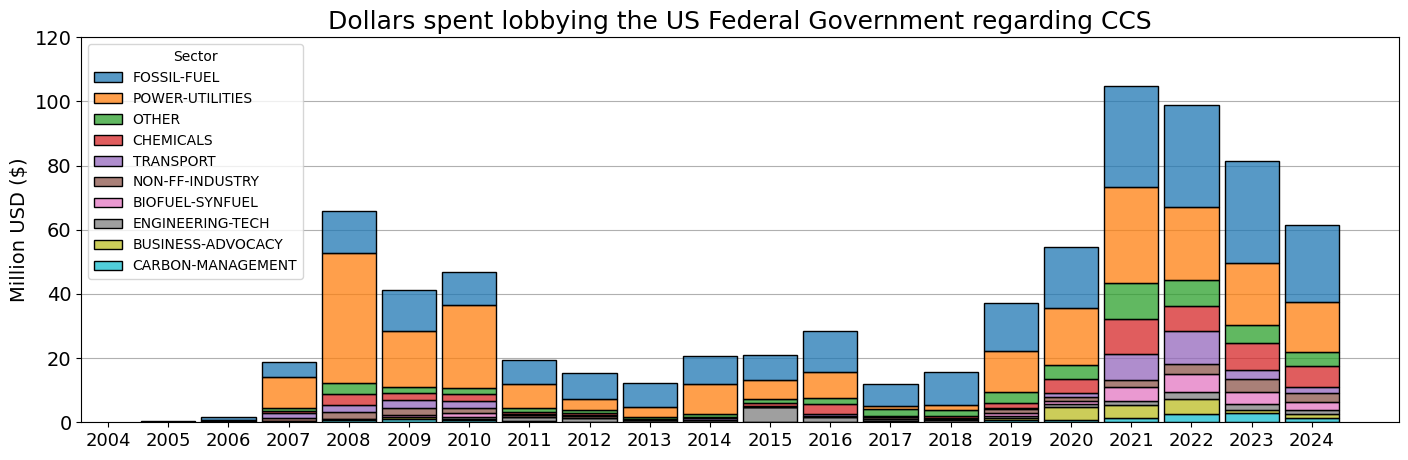

In [30]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
sector_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_df.rename(columns={"very_lumped_sector": "Sector"}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="Sector",
    hue_order=sector_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding CCS", fontsize=18
)

## Uber-lumped summary figure of lobbying through time 
same as above, but with even-more-lumped data. matches treemap

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding CCS')

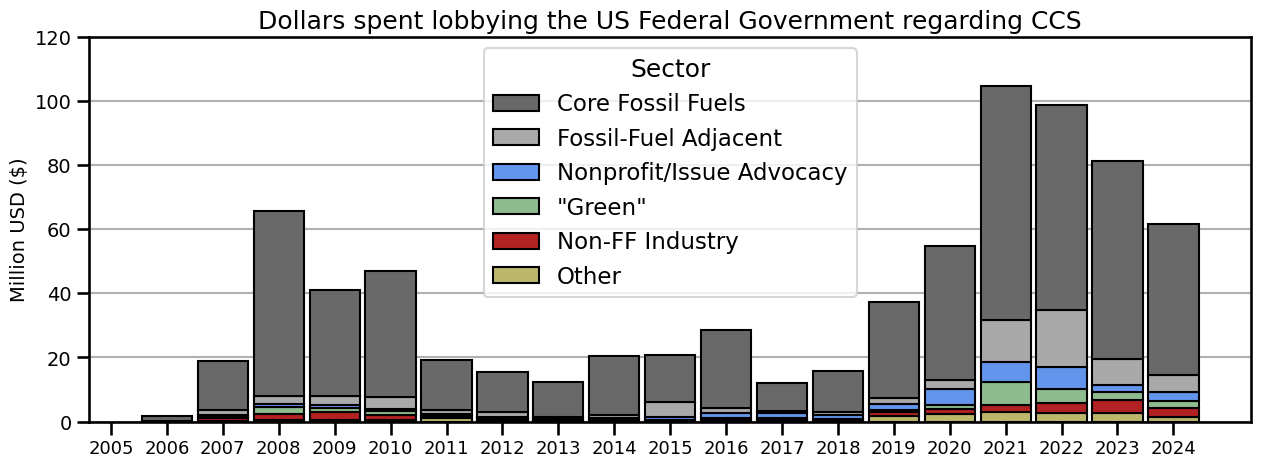

In [31]:
sns.set_context("talk")  # for histogram hue ordering
sector_for_group = "uber_lumped_sector"

# assign colors to sector groups:
uber_lumped_color_dict = {
    '"Green"': "darkseagreen",
    "Other": "darkkhaki",
    "Non-FF Industry": "firebrick",
    "Core Fossil Fuels": "dimgrey",
    "Fossil-Fuel Adjacent": "darkgrey",
    "Nonprofit/Issue Advocacy": "cornflowerblue",
}
sector_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2005, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_df.rename(columns={sector_for_group: "Sector"}, inplace=True)
# fig, ax = plt.subplots(
#    1, 1, figsize=(15, 7)
# )  # bigger for paper plot (also change legend line below)
fig, ax = plt.subplots(
    1, 1, figsize=(15, 5)
)  # thinner for presentation (also change legend line below)
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="Sector",
    hue_order=sector_order,
    shrink=0.9,
    alpha=1,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette=uber_lumped_color_dict,
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=14)
ax.set_xlabel("")
# ax.legend("")
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding CCS", fontsize=18
)

### Figure showing higher education CCS lobbying through time

Text(0.5, 1.0, 'University federal CCUS lobbying efforts')

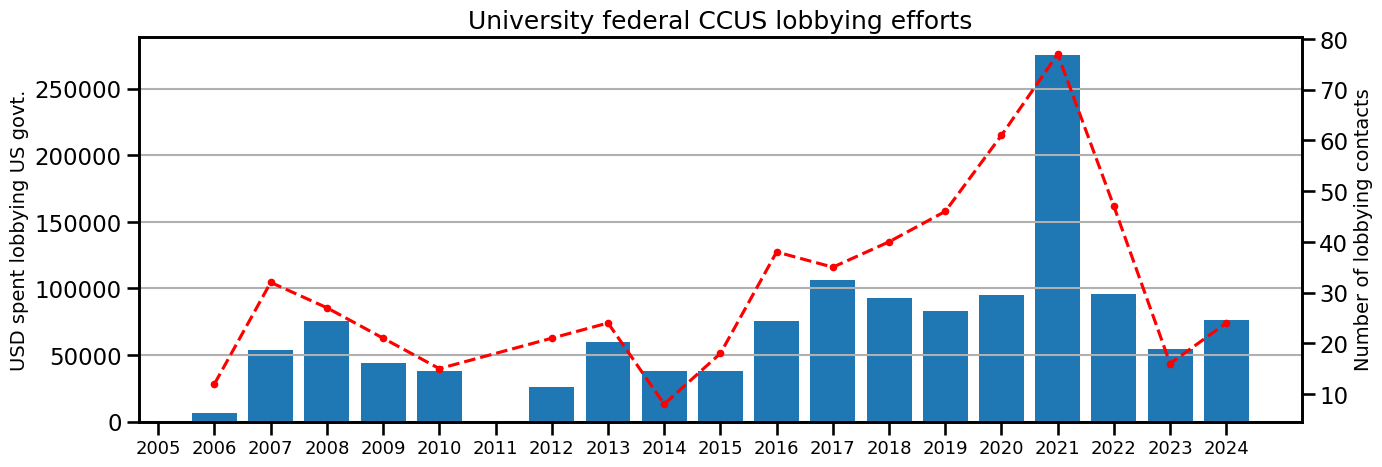

In [32]:
sns.set_context("talk")  # for histogram hue ordering:

# lobbying_activity_usd
years = list(range(2005, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", "n_entities_lobbied"]]
    .loc[(df.definitely_ccs == 1) & (df.sector == "higher education")]
    .groupby("filing_year")
    .sum()
    .reset_index()
).copy(deep=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2 = ax.twinx()
ax.bar(
    x=tmp_df.filing_year,
    height=tmp_df.lobbying_activity_usd,
)
ax2.plot(tmp_df.filing_year, tmp_df.n_entities_lobbied, "r.--")
ax2.set_ylabel("Number of lobbying contacts", fontsize=14)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.yaxis.grid()
ax.set_ylabel("USD spent lobbying US govt.", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")#
ax.set_title("University federal CCUS lobbying efforts", fontsize=18)

### Figure showing major CCS lobbiers lobbying dollars spent through time

Text(0.5, 0, '')

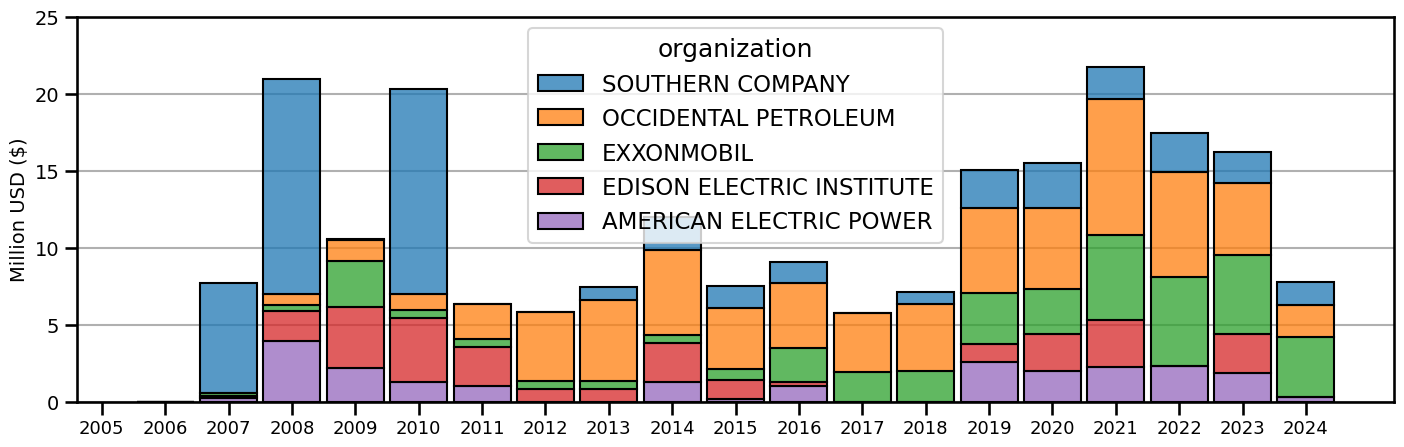

In [33]:
top_10 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
    "US CHAMBER OF COMMERCE",
    "SHELL",
    "DUKE",
    "BP AMERICA",
    "CHEVRON",
]
top_3 = ["EXXONMOBIL", "OCCIDENTAL PETROLEUM", "SOUTHERN COMPANY"]
top_5 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
]
top_df = (
    df[["lobbying_activity_usd", "n_entities_lobbied", "organization", "filing_year"]]
    .loc[(df.very_likely_ccs == 1) & (df.organization.isin(top_5))]
    .groupby(["filing_year", "organization"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)

years = list(range(2005, 2025))

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=top_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="organization",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.set_yticks(
    [
        0,
        0.05e8,
        0.1e8,
        0.15e8,
        0.20e8,
        0.25e8,
    ]
)
ax.set_yticklabels([0, 5, 10, 15, 20, 25], fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

### Quantify steel industry's environmental lobbying that *DOESNT* relate to CCS

In [34]:
steel_df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_STEEL_INDUSTRY_FILINGS),
    yr=2024,
    period=3,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)
print("We'll focus on activities that are not even potentially CCS activities: ")
steel_df.potentially_ccs.value_counts()

We'll focus on activities that are not even potentially CCS activities: 


potentially_ccs
0    6087
1     232
Name: count, dtype: int64

In [35]:
# identify lobbying activities dealing with 'environmental' subjects
steel_df["environmental"] = [
    1
    if terms_present(
        x,
        [
            "environment",
            "sustainability",
            "sustain",
            "renewable",
            "climate",
            "net zero",
            "greenhouse",
            "paris accord",
            "low carbon",
            "carbon neutral",
            "carbon-neutral",
            "emission",
            "air quality",
            "recycle",
            "recycled",
            "recycling",
            "carbon dioxide",
            "solar",
            "wind",
            "clean air",
            "co2",
            "green hydrogen",
            "carbondioxide",
            "GHG",
            "pollution",
            "green steel",
            "pollutant",
            "green h2",
            "zero emission",
            "reduced carbon",
            "zero-emission",
            "zero carbon",
            "zerocarbon",
            "lowcarbon",
            "carbonneutral",
            "earth friendly",
            "cafe standard",
            "low waste",
        ],
    )
    else 0
    for x in steel_df.cleaned_activity_description
]
# steel_df.loc[steel_df.potentially_ccs == 0].environmental.value_counts()

In [36]:
total_non_ccs_environmental_dollars_steel = steel_df.loc[
    (steel_df.environmental == 1)
    & (steel_df.potentially_ccs == 0)
    & (steel_df.sector == "iron and steel")
].lobbying_activity_usd.sum()

total_ccs_dollars_steel = steel_df.loc[
    (steel_df.definitely_ccs == 1) & (steel_df.sector == "iron and steel")
].lobbying_activity_usd.sum()
print(
    f"The steel industry spent ${total_non_ccs_environmental_dollars_steel:.0f} between 2005 and 2024 lobbying regarding non-CCS environmental topics"
)
print(
    f"The steel industry spent ${total_ccs_dollars_steel:.0f} between 2005 and 2024 lobbying about CCS"
)
print(
    f"That's a {int(total_non_ccs_environmental_dollars_steel/total_ccs_dollars_steel)}:1 difference."
)

The steel industry spent $53302725 between 2005 and 2024 lobbying regarding non-CCS environmental topics
The steel industry spent $5064781 between 2005 and 2024 lobbying about CCS
That's a 10:1 difference.


### Compute the fraction of the total CCS lobbying

In [37]:
big_spenders_total_df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_BIG_SPENDERS_FILINGS),
    yr=2024,
    period=3,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)

big_spenders_total_df.lobbying_activity_usd.fillna(0, inplace=True)

In [38]:
ccs_lobbying_df = (
    big_spenders_total_df[["organization", "lobbying_activity_usd"]]
    .loc[big_spenders_total_df.definitely_ccs == 1]
    .groupby("organization")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
ccs_lobbying_df.columns = ["ccs_lobbying_activity_usd_2005_2024"]
total_lobbying_df = (
    big_spenders_total_df[["organization", "lobbying_activity_usd"]]
    .groupby("organization")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
total_lobbying_df.columns = ["all_lobbying_activity_usd_2005_2024"]
ccs_fraction_df = total_lobbying_df.merge(
    ccs_lobbying_df, left_index=True, right_index=True, how="right"
)
ccs_fraction_df["ccs_fraction"] = [
    ccs / a if a > 0 else 0
    for ccs, a in zip(
        ccs_fraction_df["ccs_lobbying_activity_usd_2005_2024"],
        ccs_fraction_df["all_lobbying_activity_usd_2005_2024"],
    )
]
ccs_fraction_df = ccs_fraction_df[
    [
        "ccs_fraction",
        "all_lobbying_activity_usd_2005_2024",
        "ccs_lobbying_activity_usd_2005_2024",
    ]
].sort_values(
    by="ccs_lobbying_activity_usd_2005_2024",
    ascending=False,
)
ccs_fraction_df.head(30).to_clipboard()
ccs_fraction_df.head(30)

,ccs_fraction,all_lobbying_activity_usd_2005_2024,ccs_lobbying_activity_usd_2005_2024
organization,,,
OCCIDENTAL PETROLEUM,0.344055,2.033345e+08,6.995831e+07
SOUTHERN COMPANY,0.181214,3.018945e+08,5.470742e+07
EXXONMOBIL,0.116789,3.427125e+08,4.002514e+07
EDISON ELECTRIC INSTITUTE,0.087819,3.149479e+08,2.765837e+07
AMERICAN ELECTRIC POWER,0.155154,1.479940e+08,2.296191e+07
SHELL,0.104471,2.005255e+08,2.094918e+07
CHEVRON,0.060841,2.998302e+08,1.824197e+07
DUKE,0.089601,1.882239e+08,1.686501e+07
BP AMERICA,0.094566,1.642511e+08,1.553254e+07
